In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
from datetime import datetime
from astropy.coordinates import SkyCoord
import pickle
import json
import sys
import os
import pandas as pd
from sys import getsizeof
from scipy.stats import chi2
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/systematics/scripts"))
import auxiliar as aux
green = "#009736"
red = "#EE2A35"

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# dirs
objects_dir = "/fefs/aswg/workspace/juan.jimenez/systematics/objects"

target_name = "Crab"

# energy edges for lightcurve
e_lc_min = 100 * u.GeV
e_lc_max = 20 * u.TeV


#######################################
# intensity integration limits
#######################################

intensity_integration_lims = [120, 200] #p.h.
rates_fixed_point = 60 # counts 

In [2]:
def lineFreeF(params, x):
    slope, intercept = params
    return slope * np.array(x) + intercept

def lineConstF(params, x):
    intercept = params
    return np.repeat(intercept, len(x))

def lineZeroF(params, x):
    slope = params
    return slope * np.array(x)

def chi2(params, f, x, y, uy):
    y_pred = f(params, x)
    residuals = (y - y_pred) / uy
    return np.sum(residuals**2)
    
def LRTFreeConst(x, y, uy):

    init_free = [1, 1]
    init_const = [np.mean(y)]
    
    LS_free  = minimize(chi2, init_free,  args=(lineFreeF,  x, y, uy))
    LS_const = minimize(chi2, init_const, args=(lineConstF, x, y, uy))
    
    lrt = np.sqrt(LS_const.fun - LS_free.fun) #* (LS_free.fun - LS_const.fun) / np.abs(LS_free.fun - LS_const.fun)

    return lrt, LS_free.x, LS_const.x

def LRTFreeZero(x, y, uy):
    init_free = [1, 1]
    init_zero = [0]
    
    LS_free = minimize(chi2, init_free, args=(lineFreeF, x, y, uy))
    LS_zero = minimize(chi2, init_zero, args=(lineZeroF, x, y, uy))
    
    lrt = np.sqrt(LS_zero.fun - LS_free.fun)

    return lrt, LS_free.x, LS_zero.x

### Reading all the objects and putting all the information in a unique dict

In [3]:
%%time
###################
# reading objects
###################
# light curve data
with open(f'{objects_dir}/dict_LC.pkl', 'rb') as f:
    dict_LC = pickle.load(f)

dict_LC_2 = {}
for i, run in enumerate(np.array(dict_LC["run_number"]).astype(int)):
    tmp_dict = {
        "flux" : dict_LC["flux"][i] * 1e10, 
        "e_flux" : dict_LC["e_flux"][i] * 1e10, 
        "timestamp" : dict_LC["timestamp"][i], 
        "duration" : dict_LC["duration"][i], 
        "zd" : dict_LC["zd"][i],
        "az" : dict_LC["az"][i]
    }
    dict_LC_2[run] = tmp_dict
    
# l2 to dl3 information
with open(f"{objects_dir}/total_dict_runs.json", "r") as json_file:
    dict_dl2todl3 = json.load(json_file)
    
# load dl2 desired data
with open('objects/dict_dl2.pkl', 'rb') as f:
    dict_dl2 = pickle.load(f)
    
dict_runs = {}

for run in dict_dl2.keys():
    
    tmp_dict = {
        "flux" : dict_LC_2[run]["flux"].value,
        "e_flux": dict_LC_2[run]["e_flux"].value,
        "zd" : dict_LC_2[run]["zd"].value,
        "az" : dict_LC_2[run]["az"].value,
        "timestamp" : dict_LC_2[run]["timestamp"],
        "effective_time" : dict_dl2[run]["effective_time"],
    }
    
    dict_runs[run] = tmp_dict

CPU times: user 1.09 s, sys: 23 s, total: 24.1 s
Wall time: 1min 40s


### Time correction

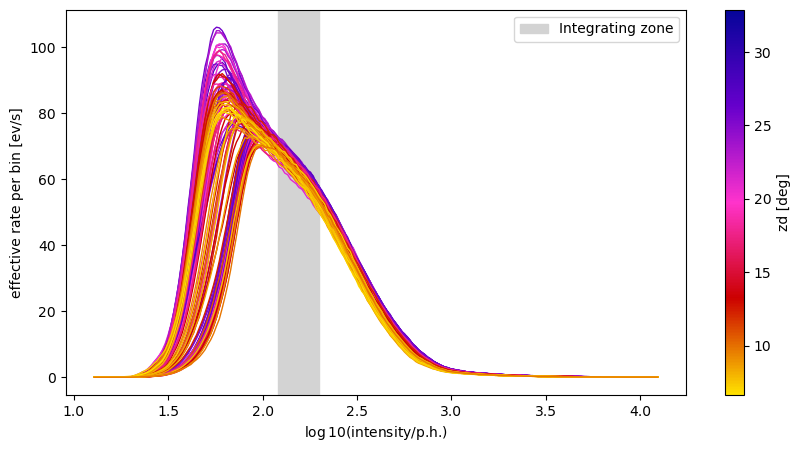

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

bins = np.linspace(1.1, 4.1, 200) 

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    counts   = counts / dict_dl2[run]["effective_time"]
    
    integral = 0
    for i, b in enumerate(bins[:-1]):
        if bins[i] > np.log10(intensity_integration_lims[0]) and bins[i+1] < np.log10(intensity_integration_lims[1]):
            integral = integral + counts[i]
    
    dict_runs[run]["p_rate"] = integral
    
    ax.plot(Icenters, counts, color=color, lw=1)

ax.axvspan(np.log10(intensity_integration_lims[0]), np.log10(intensity_integration_lims[1]), color="lightgray", label="Integrating zone")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.legend()
ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
plt.show()

### Extracting all the values in arrays

In [5]:
# extracting values as arrays
p_rate   = []
e_p_rate = [] 
flux   = []
e_flux = []
zd, az = [], []
e_zd, e_az = [], []

for run in dict_runs.keys():
    flux.append(dict_runs[run]["flux"])
    e_flux.append(dict_runs[run]["e_flux"])
    zd.append(dict_runs[run]["zd"])
    az.append(dict_runs[run]["az"])
    p_rate.append(dict_runs[run]["p_rate"])
    
    _e_p_rate = np.sqrt(len(dict_dl2[run]["zd"])) / dict_runs[run]["effective_time"]
    _e_zd = np.abs(dict_dl2[run]["zd"][0] - dict_dl2[run]["zd"][-1]) / 2
    _e_az = np.abs(dict_dl2[run]["az"][0] - dict_dl2[run]["az"][-1]) / 2
    
    dict_runs[run]["e_p_rate"] = _e_p_rate
    dict_runs[run]["e_zd"] = _e_zd
    dict_runs[run]["e_az"] = _e_az
    
    e_p_rate.append(_e_p_rate)
    e_zd.append(_e_zd)
    e_az.append(_e_az)

flux   = np.array(flux)
e_flux = np.array(e_flux)
p_rate = np.array(p_rate)
zd = np.array(zd)
az = np.array(az)

### The p_rate distributions

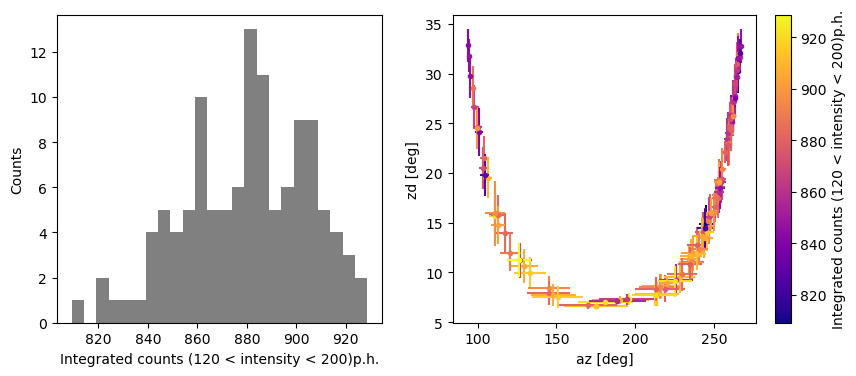

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1.2, 1.4]})

bins = np.linspace(np.min(p_rate), np.max(p_rate), 25)
ax1.hist(p_rate, bins, color="gray")

norm   = mpl.colors.Normalize(vmin=np.min(p_rate), vmax=np.max(p_rate))
colors = mpl.cm.ScalarMappable(norm,"plasma").to_rgba(p_rate)
for i in range(len(az)):
    ax2.errorbar(az[i], zd[i], xerr=e_az[i], yerr=e_zd[i], ls="", marker=".", color=colors[i])

#######################################
# creating a colorbar
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
#######################################

ax1.set_ylabel("Counts")
ax1.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel("az [deg]")
ax2.set_ylabel("zd [deg]")
plt.show()

### Linearly fitting the zd to the proton rate and showing all distributions

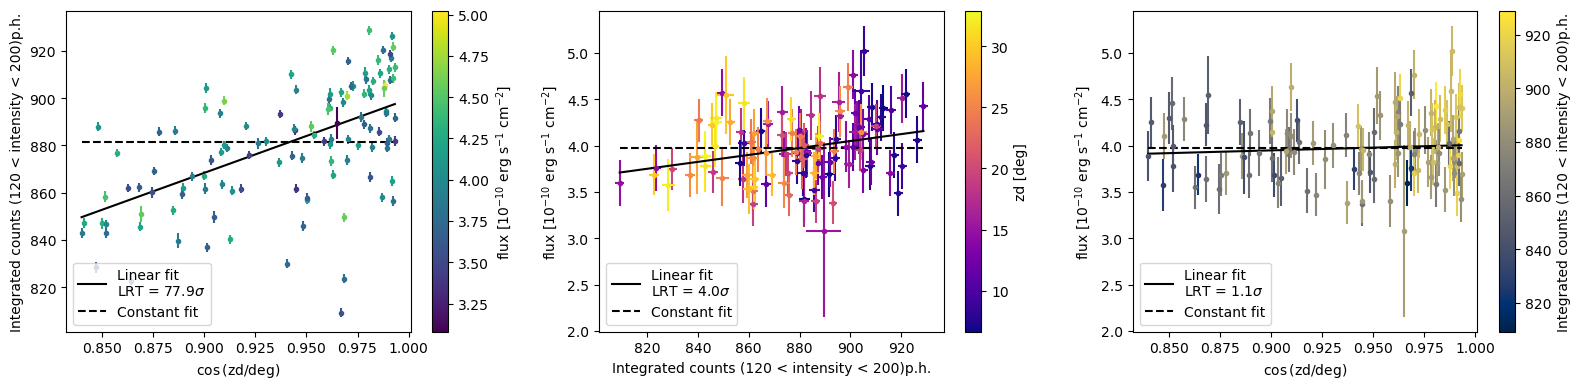

In [7]:
# Perform linear fits
fitF_zd_p = np.poly1d(np.polyfit(np.cos(np.deg2rad(zd)), p_rate, 1)) 
fitF_p_f  = np.poly1d(np.polyfit(p_rate,                 flux, 1)) 
fitF_zd_f = np.poly1d(np.polyfit(np.cos(np.deg2rad(zd)), flux, 1)) 
    
############################################
# plot the figures
############################################
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

norm_zd   = mpl.colors.Normalize(vmin=np.min(zd), vmax=np.max(zd))
colors_zd = mpl.cm.ScalarMappable(norm_zd,"plasma").to_rgba(zd)

norm_p   = mpl.colors.Normalize(vmin=np.min(p_rate), vmax=np.max(p_rate))
colors_p = mpl.cm.ScalarMappable(norm_p,"cividis").to_rgba(p_rate)

norm_f   = mpl.colors.Normalize(vmin=np.min(flux), vmax=np.max(flux))
colors_f = mpl.cm.ScalarMappable(norm_f,"viridis").to_rgba(flux)

for i in range(len(az)):
    ax1.errorbar(np.cos(np.deg2rad(zd[i])), p_rate[i], xerr=0,           yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])
    ax2.errorbar(p_rate[i],                 flux[i],   xerr=e_p_rate[i], yerr=e_flux[i],   ls="", marker=".", color=colors_zd[i])
    ax3.errorbar(np.cos(np.deg2rad(zd[i])), flux[i],   xerr=0,           yerr=e_flux[i],   ls="", marker=".", color=colors_p[i])

#######################################
# creating a colorbar
sm_zd = plt.cm.ScalarMappable(cmap="plasma",  norm=norm_zd)
sm_p  = plt.cm.ScalarMappable(cmap="cividis", norm=norm_p)
sm_f  = plt.cm.ScalarMappable(cmap="viridis", norm=norm_f)
for sm in [sm_zd, sm_p, sm_f]:
    sm.set_array([])
fig.colorbar(sm_f,  ax=ax1, label= "flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
fig.colorbar(sm_zd, ax=ax2, label=f"zd [deg]")
fig.colorbar(sm_p,  ax=ax3, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

#######################################

####################
# plot lines
####################
zd_array = np.linspace(min(np.cos(np.deg2rad(zd))), max(np.cos(np.deg2rad(zd))), 200)
p_array  = np.linspace(min(p_rate), max(p_rate), 200)

LRT_zd_p = LRTFreeConst(np.cos(np.deg2rad(zd)), p_rate, e_p_rate)
LRT_p_f  = LRTFreeConst(p_rate,                 flux,   e_flux)
LRT_zd_f = LRTFreeConst(np.cos(np.deg2rad(zd)), flux,   e_flux)

sigma = "$\sigma$"
ax1.plot(zd_array, lineFreeF(LRT_zd_p[1], zd_array), '-k', label=f"Linear fit\nLRT = {LRT_zd_p[0]:.1f}{sigma}")
ax2.plot(p_array,  lineFreeF(LRT_p_f[1],  p_array), '-k', label=f"Linear fit\nLRT = {LRT_p_f[0]:.1f}{sigma}")
ax3.plot(zd_array, lineFreeF(LRT_zd_f[1], zd_array), '-k', label=f"Linear fit\nLRT = {LRT_zd_f[0]:.1f}{sigma}")

ax1.plot(zd_array, lineConstF(LRT_zd_p[2], zd_array), '--k', label=f"Constant fit")
ax2.plot(p_array,  lineConstF(LRT_p_f[2],  p_array), '--k', label=f"Constant fit")
ax3.plot(zd_array, lineConstF(LRT_zd_f[2], zd_array), '--k', label=f"Constant fit")

for ax in [ax1, ax2, ax3]:
    ax.legend(loc=3)
ax1.set_ylabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax1.set_xlabel("$\cos$(zd/deg)")
ax2.set_ylabel("flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax3.set_ylabel("flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
ax3.set_xlabel(f"$\cos$(zd/deg)")

fig.tight_layout()
plt.show()

### Re-scaling the proton rate as it should be in zd=0

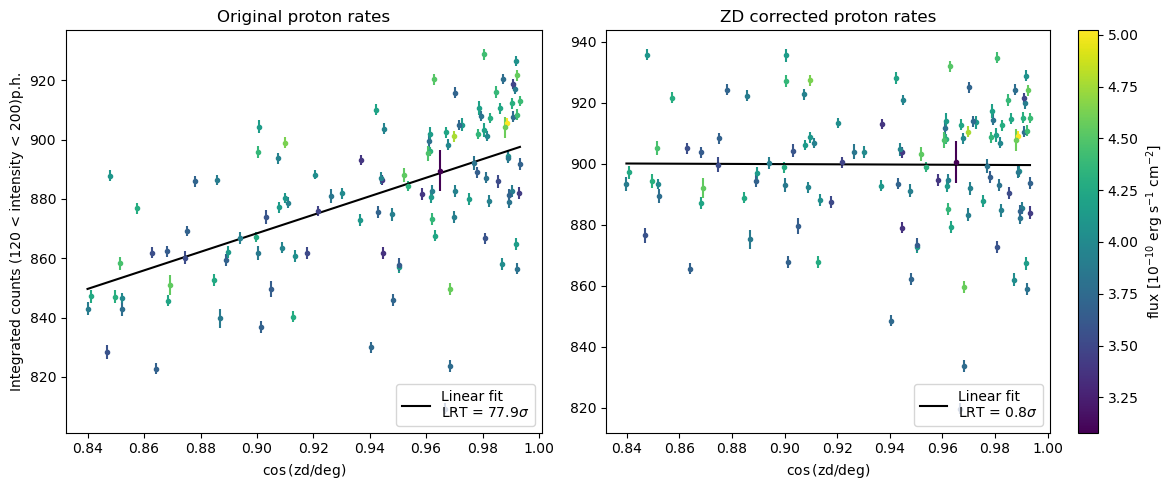

In [8]:
zd_0_p_rate = []
for run in dict_runs.keys():
    
    _zd_0_p_rate = dict_runs[run]["p_rate"] - fitF_zd_p(np.cos(np.deg2rad(dict_runs[run]["zd"]))) + fitF_zd_p(1)
    
    dict_runs[run]["zd_0_p_rate"] = _zd_0_p_rate
    zd_0_p_rate.append(_zd_0_p_rate)

    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.4]})

norm_f   = mpl.colors.Normalize(vmin=np.min(flux), vmax=np.max(flux))
colors_f = mpl.cm.ScalarMappable(norm_f,"viridis").to_rgba(flux)

for i in range(len(az)):
    ax1.errorbar(np.cos(np.deg2rad(zd[i])), p_rate[i],      xerr=0, yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])
    ax2.errorbar(np.cos(np.deg2rad(zd[i])), zd_0_p_rate[i], xerr=0, yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])

#######################################
# creating a colorbar
sm_f  = plt.cm.ScalarMappable(cmap="viridis", norm=norm_f)
sm_f.set_array([])
fig.colorbar(sm_f, ax=ax2, label="flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
#######################################

####################
# plot lines
####################
LRT_zd_p   = LRTFreeConst(np.cos(np.deg2rad(zd)), p_rate,      e_p_rate)
LRT_zd_0_p = LRTFreeConst(np.cos(np.deg2rad(zd)), zd_0_p_rate, e_p_rate)

ax1.plot(zd_array, lineFreeF(LRT_zd_p[1],   zd_array), '-k', label=f"Linear fit\nLRT = {LRT_zd_p[0]:.1f}{sigma}")
ax2.plot(zd_array, lineFreeF(LRT_zd_0_p[1], zd_array), '-k', label=f"Linear fit\nLRT = {LRT_zd_0_p[0]:.1f}{sigma}")

# ax1.plot(zd_array, lineConstF(LRT_zd_p[2],   zd_array), '--k', label=f"Constant fit")
# ax2.plot(zd_array, lineConstF(LRT_zd_0_p[2], zd_array), '--k', label=f"Constant fit")

for ax in [ax1, ax2]:
    ax.legend(loc=4)
    ax.set_xlabel("$\cos$(zd/deg)")
ax1.set_ylabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax1.set_title("Original proton rates")
ax2.set_title("ZD corrected proton rates")

fig.tight_layout()
plt.show()

### Fitting the flux vs the proton rate with a stright line passing trough (0,0)

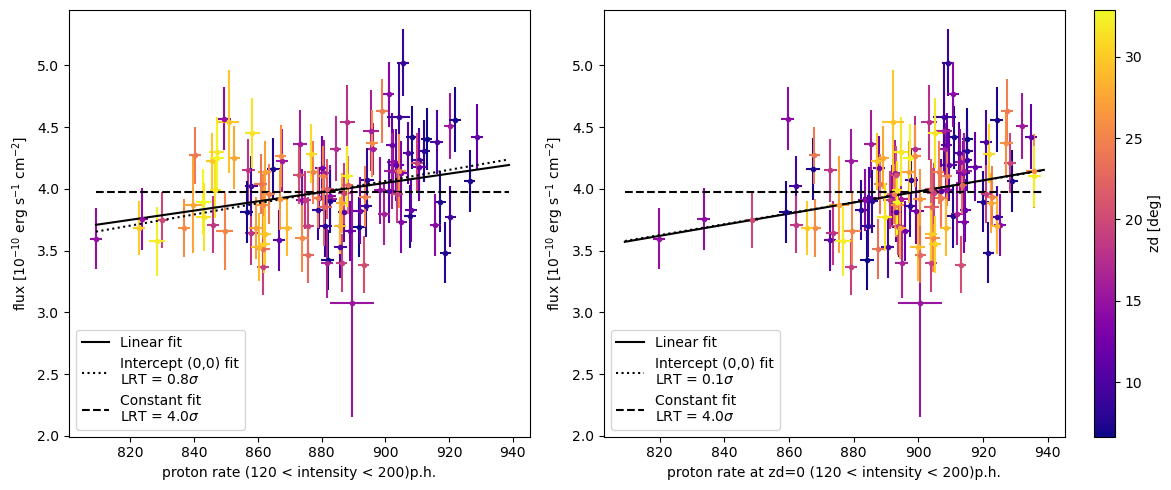

In [9]:
slope      = np.dot(p_rate,      flux) / np.dot(p_rate, p_rate)
zd_0_slope = np.dot(zd_0_p_rate, flux) / np.dot(zd_0_p_rate, zd_0_p_rate)

def fit_flux(x_value, slope):
    return slope * x_value

for run in dict_runs.keys():
    _factor = fit_flux(dict_runs[run]["zd_0_p_rate"], zd_0_slope) / dict_runs[run]["flux"]
    dict_runs[run]["zd_corr"] = _factor
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.5]})


norm_zd   = mpl.colors.Normalize(vmin=np.min(zd), vmax=np.max(zd))
colors_zd = mpl.cm.ScalarMappable(norm_zd,"plasma").to_rgba(zd)

for i in range(len(az)):
    ax1.errorbar(p_rate[i],      flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
    ax2.errorbar(zd_0_p_rate[i], flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])

#######################################
# creating a colorbar
sm_zd  = plt.cm.ScalarMappable(cmap="plasma", norm=norm_zd)
sm_zd.set_array([])
fig.colorbar(sm_zd, ax=ax2, label="zd [deg]")
#######################################

####################
p_array = np.linspace(min(p_rate), max(p_rate)+10, 200)
LRT_p_f      = LRTFreeConst(p_rate,      flux, e_flux)
LRT_corr_p_f = LRTFreeConst(zd_0_p_rate, flux, e_flux)
LRT_p_f_0      = LRTFreeZero(p_rate,      flux, e_flux)
LRT_corr_p_f_0 = LRTFreeZero(zd_0_p_rate, flux, e_flux)

ax1.plot(p_array, lineFreeF(LRT_p_f[1],      p_array), '-k', label=f"Linear fit")
ax2.plot(p_array, lineFreeF(LRT_corr_p_f[1], p_array), '-k', label=f"Linear fit")

ax1.plot(p_array, lineZeroF(LRT_p_f_0[2],      p_array), ':k', label=f"Intercept (0,0) fit\nLRT = {LRT_p_f_0[0]:.1f}{sigma}")
ax2.plot(p_array, lineZeroF(LRT_corr_p_f_0[2], p_array), ':k', label=f"Intercept (0,0) fit\nLRT = {LRT_corr_p_f_0[0]:.1f}{sigma}")

ax1.plot(p_array, lineConstF(LRT_p_f[2],      p_array), '--k', label=f"Constant fit\nLRT = {LRT_p_f[0]:.1f}{sigma}")
ax2.plot(p_array, lineConstF(LRT_corr_p_f[2], p_array), '--k', label=f"Constant fit\nLRT = {LRT_corr_p_f[0]:.1f}{sigma}")

for ax in [ax1, ax2]:
    ax.legend(loc=3)
ax1.set_ylabel("flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_ylabel("flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
ax1.set_xlabel(f"proton rate ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel(f"proton rate at zd=0 ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

fig.tight_layout()
plt.show()

### Applying the corrections to the flux

In [10]:
corr = "zd_corr"
zd_corr_flux = []
mean_flux = np.mean(flux) #fit_flux(np.mean(dict_runs[run]["zd_0_p_rate"]))

for run in dict_runs.keys():
    
    _zd_corr_flux = dict_runs[run]["flux"] - (fit_flux(dict_runs[run]["zd_0_p_rate"], zd_0_slope) - mean_flux)
    zd_corr_flux.append(_zd_corr_flux)
    dict_runs[run]["zd_corr_flux"] = _zd_corr_flux

zd_corr_flux = np.array(zd_corr_flux)

### Plotting the corrections

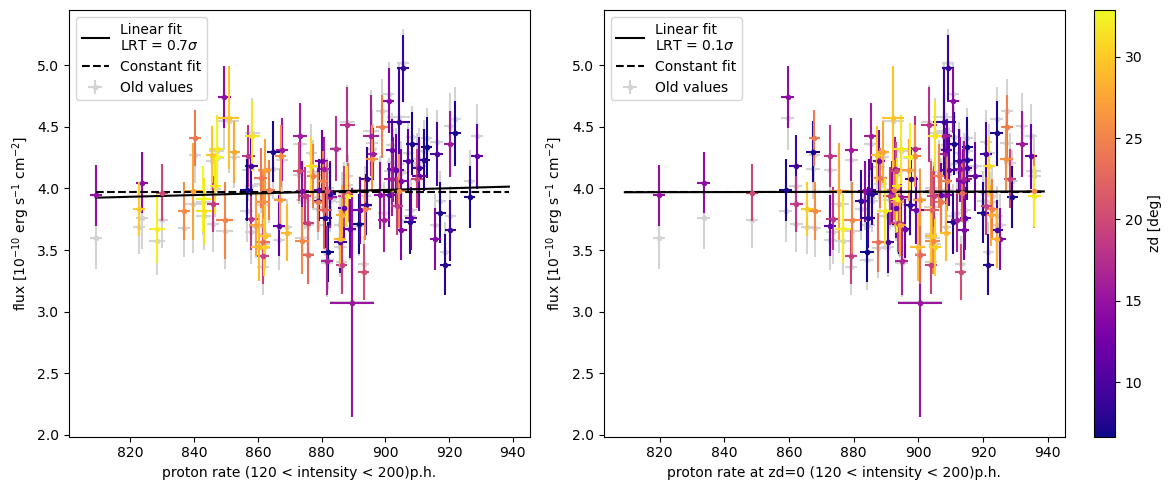

In [11]:
fitF_p_cf  = np.poly1d(np.polyfit(p_rate, zd_corr_flux, 1)) 
fitF_cp_cf = np.poly1d(np.polyfit(zd_0_p_rate, zd_corr_flux, 1)) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.5]})

norm_zd   = mpl.colors.Normalize(vmin=np.min(zd), vmax=np.max(zd))
colors_zd = mpl.cm.ScalarMappable(norm_zd,"plasma").to_rgba(zd)

for i in range(len(az)):
    ax1.errorbar(p_rate[i],      zd_corr_flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
    ax2.errorbar(zd_0_p_rate[i], zd_corr_flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
ax1.errorbar(p_rate,      flux, xerr=e_p_rate, yerr=e_flux, ls="", marker=".", color="lightgray", zorder=-10, label="Old values")
ax2.errorbar(zd_0_p_rate, flux, xerr=e_p_rate, yerr=e_flux, ls="", marker=".", color="lightgray", zorder=-10, label="Old values")

#######################################
# creating a colorbar
sm_zd  = plt.cm.ScalarMappable(cmap="plasma", norm=norm_zd)
sm_zd.set_array([])
fig.colorbar(sm_zd, ax=ax2, label="zd [deg]")
#######################################
p_array = np.linspace(min(p_rate), max(p_rate)+10, 200)
LRT_p_f      = LRTFreeConst(p_rate,      zd_corr_flux, e_flux)
LRT_corr_p_f = LRTFreeConst(zd_0_p_rate, zd_corr_flux, e_flux)

ax1.plot(p_array, lineFreeF(LRT_p_f[1],      p_array), '-k', label=f"Linear fit\nLRT = {LRT_p_f[0]:.1f}{sigma}")
ax2.plot(p_array, lineFreeF(LRT_corr_p_f[1], p_array), '-k', label=f"Linear fit\nLRT = {LRT_corr_p_f[0]:.1f}{sigma}")

ax1.plot(p_array, lineConstF(LRT_p_f[2],      p_array), '--k', label=f"Constant fit")
ax2.plot(p_array, lineConstF(LRT_corr_p_f[2], p_array), '--k', label=f"Constant fit")

ax1.legend()
ax2.legend()
ax1.set_ylabel("flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_ylabel("flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
ax1.set_xlabel(f"proton rate ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel(f"proton rate at zd=0 ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

fig.tight_layout()
plt.show()

### Plotting the Light Curve

Flux original       = 3.986 ± 0.341   [e-10 erg / (s cm2)]
Flux zd correction  = 3.985 ± 0.327   [e-10 erg / (s cm2)]


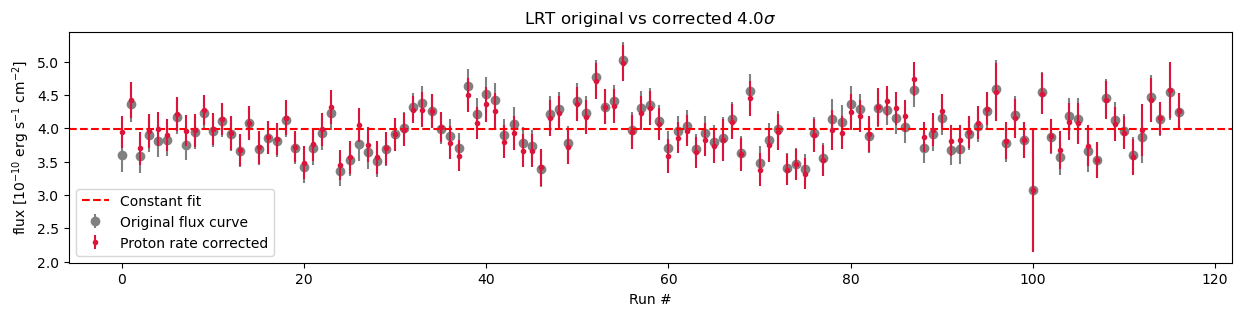

In [12]:
chi, zd_corr_chi = [], []

for run in dict_runs.keys():
    if run > 0:
        chi.append((dict_runs[run]["flux"] - np.mean(flux)) / dict_runs[run]["e_flux"])
        zd_corr_chi.append((dict_runs[run]["zd_corr_flux"] - np.mean(zd_corr_flux)) / dict_runs[run]["e_flux"])


units = "[e-10 erg / (s cm2)]"
print(f"Flux original       = {np.mean(flux):.3f} ± {np.std(flux):.3f}   {units}")
print(f"Flux zd correction  = {np.mean(zd_corr_flux):.3f} ± {np.std(zd_corr_flux):.3f}   {units}")

fig, ax = plt.subplots(figsize=(15, 3))

for i, run in enumerate(dict_LC_2.keys()):  

    if i == 0:
        label = "Original flux curve"
        label_zd  = "Proton rate corrected"
    else:   
        label, label_zd = None, None
        
    errors = dict_runs[run]["e_flux"]
    flux_value         = dict_runs[run]["flux"]
    zd_corr_flux_value = dict_runs[run]["zd_corr_flux"]
    
    ax.errorbar(i, flux_value,         yerr=errors, marker="o", ls="", color="gray",  zorder=-10, label=label)
    ax.errorbar(i, zd_corr_flux_value, yerr=errors, marker=".", ls="", color="crimson", label=label_zd)

ax.axhline(np.mean(zd_corr_flux), color="r", ls="--", label=f"Constant fit")
    
ax.legend(loc=3, ncol=1)
ax.set_xlabel(f"Run #")
ax.set_ylabel("flux [$10^{-10}$ erg s${}^{-1}$ cm${}^{-2}$]")
        
chi2_arr = np.sum(np.array(chi) ** 2) 
zd_corr_chi2_arr = np.sum(np.array(zd_corr_chi) ** 2) 
        
ax.set_title(f"LRT original vs corrected {np.sqrt(chi2_arr - zd_corr_chi2_arr):.1f}{sigma}")
plt.show()

### Calculating the chi2 distributions

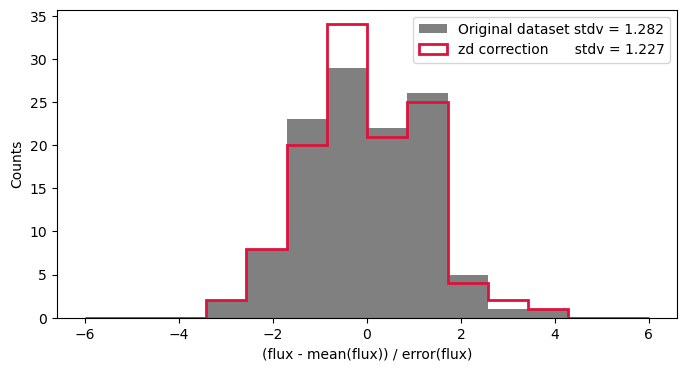

In [13]:
bins = np.linspace(-6, 6, 15)

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(np.array(chi),         bins=bins, color="gray", label=f"Original dataset stdv = {np.std(chi):.3f}")
ax.hist(np.array(zd_corr_chi), bins=bins, color="crimson", histtype="step", lw=2, label=f"zd correction      stdv = {np.std(zd_corr_chi):.3f}")


ax.legend()
ax.set_ylabel("Counts")
ax.set_xlabel("(flux - mean(flux)) / error(flux)")
plt.show()

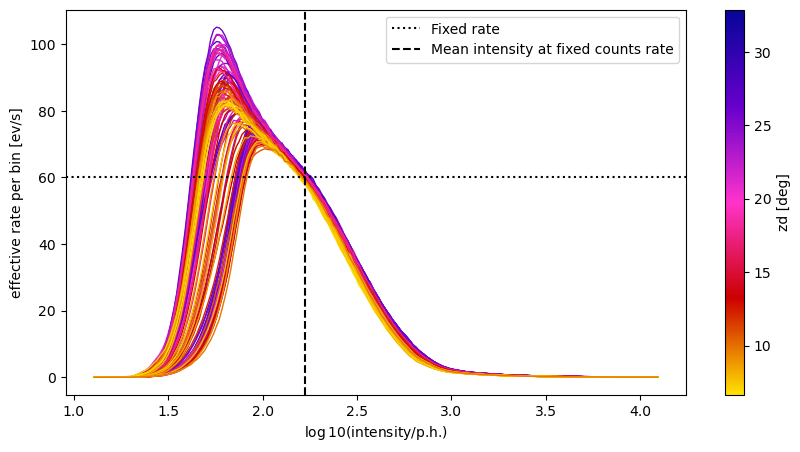

In [14]:
INT = []
bins_fixed = []

fig, ax = plt.subplots(figsize=(10, 5))

bins = np.linspace(1.1, 4.1, 200) 

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    
    C = dict_runs[run]["zd_corr_flux"] / dict_runs[run]["flux"]
    
    counts   = counts / dict_dl2[run]["effective_time"]  * C
    
    ax.plot(Icenters, counts, color=color, lw=1)

    integral = 0
    for i, b in enumerate(bins[:-1]):
        if bins[i] > np.log10(intensity_integration_lims[0]) and bins[i+1] < np.log10(intensity_integration_lims[1]):
            integral = integral + counts[i]
    INT.append(integral)

    for i in range(len(bins)-1):
        if bins[i] > 2.:
            if counts[i] > rates_fixed_point and counts[i+1] <= rates_fixed_point:
                bins_fixed.append(bins[i]/2 + bins[i+1]/2) 
                dict_runs[run]["int_at_fixed_rate"] = bins[i]/2 + bins[i+1]/2
        
bins_fixed = np.array(bins_fixed)
INT = np.array(INT)

ax.axhline(rates_fixed_point,   color="k", ls=":", label="Fixed rate")
ax.axvline(np.mean(bins_fixed), color="k", ls="--", label="Mean intensity at fixed counts rate")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.legend()
ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
plt.show()

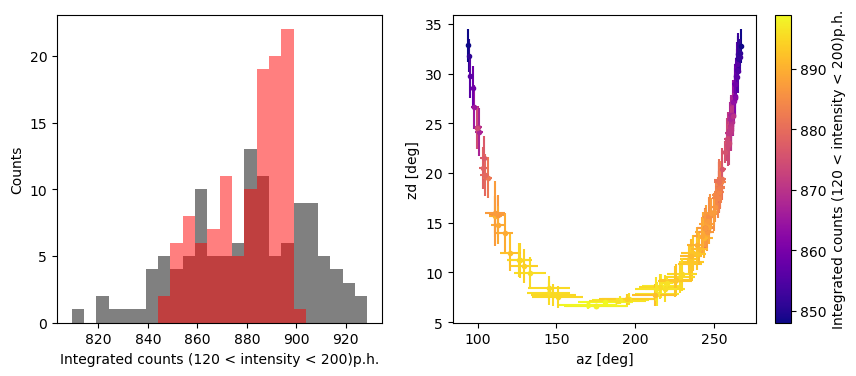

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1.2, 1.4]})

bins = np.linspace(np.min(p_rate), np.max(p_rate), 25)
ax1.hist(p_rate, bins, color="gray")
ax1.hist(INT, bins, color="red", alpha=0.5)

norm   = mpl.colors.Normalize(vmin=np.min(INT), vmax=np.max(INT))
colors = mpl.cm.ScalarMappable(norm,"plasma").to_rgba(INT)
for i in range(len(az)):
    ax2.errorbar(az[i], zd[i], xerr=e_az[i], yerr=e_zd[i], ls="", marker=".", color=colors[i])

#######################################
# creating a colorbar
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
#######################################

ax1.set_ylabel("Counts")
ax1.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel("az [deg]")
ax2.set_ylabel("zd [deg]")
plt.show()

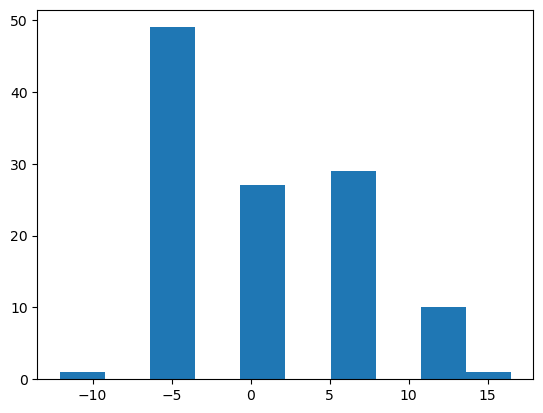

In [18]:
plt.hist(10**np.mean(bins_fixed) - 10**np.array(bins_fixed));

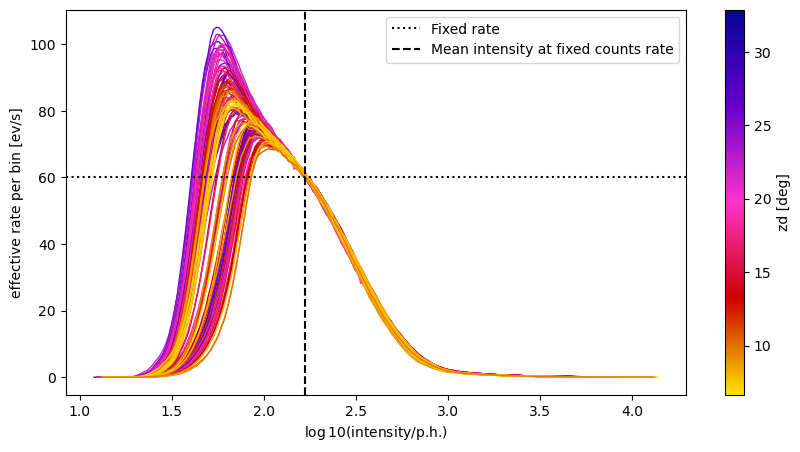

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

bins = np.linspace(1.1, 4.1, 200) 

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    
    C = dict_runs[run]["zd_corr_flux"] / dict_runs[run]["flux"]
    
    counts   = counts / dict_dl2[run]["effective_time"]  * C
    
    D = np.mean(bins_fixed) - dict_runs[run]["int_at_fixed_rate"]
    Icenters = Icenters + D
    ax.plot(Icenters, counts, color=color, lw=1)

                
ax.axhline(rates_fixed_point,   color="k", ls=":", label="Fixed rate")
ax.axvline(np.mean(bins_fixed), color="k", ls="--", label="Mean intensity at fixed counts rate")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.legend()
ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
plt.show()